In [1]:
SOURCE_VIDEO_PATH = f"data/video/example.mp4"

In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.40 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
Setup complete ✅ (80 CPUs, 754.5 GB RAM, 4012.6/4434.8 GB disk)


In [3]:
from tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [4]:
from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [5]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [6]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [7]:
# settings
MODEL = "weights/yolov8n-face.pt"
# MODEL = "yolov5/runs/train/exp6/weights/best.pt"

In [8]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8n-pose summary (fused): 187 layers, 3078128 parameters, 0 gradients, 8.3 GFLOPs


## Predict and annotate single frame

In [9]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0]


0: 384x640 (no detections), 96.8ms
Speed: 6.4ms preprocess, 96.8ms inference, 18.9ms postprocess per image at shape (1, 3, 384, 640)


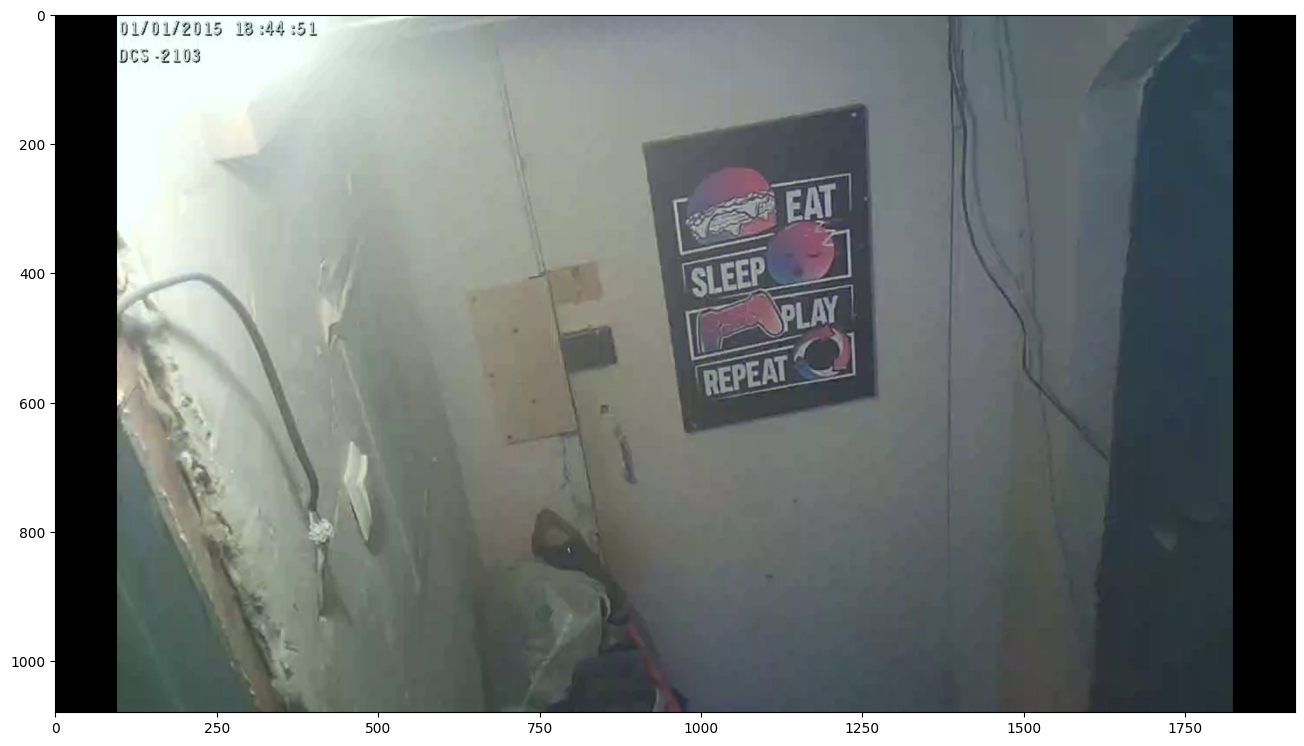

In [17]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink("data/video/output_detect.mp4", video_info) as sink:
    # loop over video frames
    for frame in generator:
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # format custom labels
        labels = [
            f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        sink.write_frame(frame)


## Predict and annotate whole video

In [10]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"data/video/output_test1.mp4"

In [11]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=907)

In [ ]:
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)


# create list of dicts for data of faces (final images of faces)

detected_faces = []

# create lists for meta_data
frame_id = 0

meta = {}
meta1 = []


# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in generator:
        meta_objects_id = []
        meta_bboxes = []
        meta_bboxes_size = []
        
        objects_dict = {}
        bbox_xyxy_dict = {}
        bbox_dict = {}
        
        frame_buf = frame
        # model prediction on single frame and conversion to supervision Detections
           
        results = model(frame)
        
        
        
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # collecting data for final face images
        # collecting meta_data 
        for xyxy, confidence, class_id, tracker_id in detections:            
            
            detected_faces = ({'id': tracker_id, 'confidence': confidence, 'image': frame_buf, 'coordinates': xyxy})
            
            meta_objects_id.append(tracker_id)
            meta_bboxes.append({'confidence': confidence,'coordinates': xyxy})
            meta_bboxes_size.append({'width': (xyxy[2] - xyxy[0]),'height': (xyxy[3] - xyxy[1])})
            
            bbox_xyxy_dict['x_min'] = float(xyxy[0])
            bbox_xyxy_dict['x_max'] = float(xyxy[2])
            bbox_xyxy_dict['y_min'] = float(xyxy[1])
            bbox_xyxy_dict['y_max'] = float(xyxy[3])
            
            bbox_dict['bbox_xyxy'] = bbox_xyxy_dict
            bbox_dict['bbox_width'] = float((xyxy[2] - xyxy[0]))
            bbox_dict['bbox_height'] =  float((xyxy[3] - xyxy[1]))
            bbox_dict['confidence'] = float(confidence)
            
            objects_dict[('object_id ' + (str(tracker_id)))] = bbox_dict
            
            
        meta[('frame_id ' + (str(frame_id)))] = objects_dict
        
        meta1.append({'object id': meta_objects_id, 'bboxes': meta_bboxes, 'bboxes size': meta_bboxes_size})
        
        
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        
        
        
        
        
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)
        frame_id +=1


## Adding metaimport json

In [13]:
import json

In [17]:

json_data = json.dumps(meta, default=lambda x: x.__dict__, indent=4)
with open('meta.json', 'w') as f:
    f.write(json_data)

In [18]:
# Прочитать JSON данные из файла
with open('meta.json', 'r') as f:
    json_data = json.load(f)

# json_data теперь содержит данные, загруженные из JSON файла
print(json_data)

{'frame_id 0': {}, 'frame_id 1': {}, 'frame_id 2': {}, 'frame_id 3': {}, 'frame_id 4': {}, 'frame_id 5': {}, 'frame_id 6': {}, 'frame_id 7': {}, 'frame_id 8': {}, 'frame_id 9': {}, 'frame_id 10': {}, 'frame_id 11': {}, 'frame_id 12': {}, 'frame_id 13': {}, 'frame_id 14': {}, 'frame_id 15': {}, 'frame_id 16': {}, 'frame_id 17': {}, 'frame_id 18': {}, 'frame_id 19': {}, 'frame_id 20': {}, 'frame_id 21': {}, 'frame_id 22': {}, 'frame_id 23': {}, 'frame_id 24': {}, 'frame_id 25': {}, 'frame_id 26': {}, 'frame_id 27': {}, 'frame_id 28': {}, 'frame_id 29': {}, 'frame_id 30': {}, 'frame_id 31': {}, 'frame_id 32': {}, 'frame_id 33': {}, 'frame_id 34': {}, 'frame_id 35': {}, 'frame_id 36': {}, 'frame_id 37': {}, 'frame_id 38': {}, 'frame_id 39': {}, 'frame_id 40': {}, 'frame_id 41': {}, 'frame_id 42': {}, 'frame_id 43': {}, 'frame_id 44': {}, 'frame_id 45': {}, 'frame_id 46': {}, 'frame_id 47': {}, 'frame_id 48': {}, 'frame_id 49': {}, 'frame_id 50': {}, 'frame_id 51': {}, 'frame_id 52': {}, 'f

## Getting crops of frames with faces

In [38]:
from PIL import Image

import matplotlib.pyplot as plt
from io import BytesIO
import imageio
import cv2

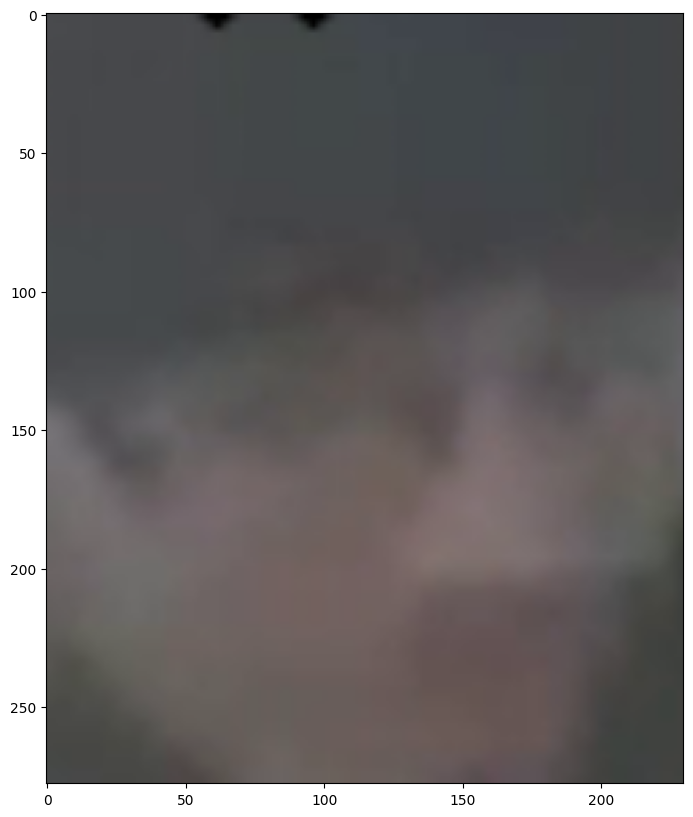

0.71009743


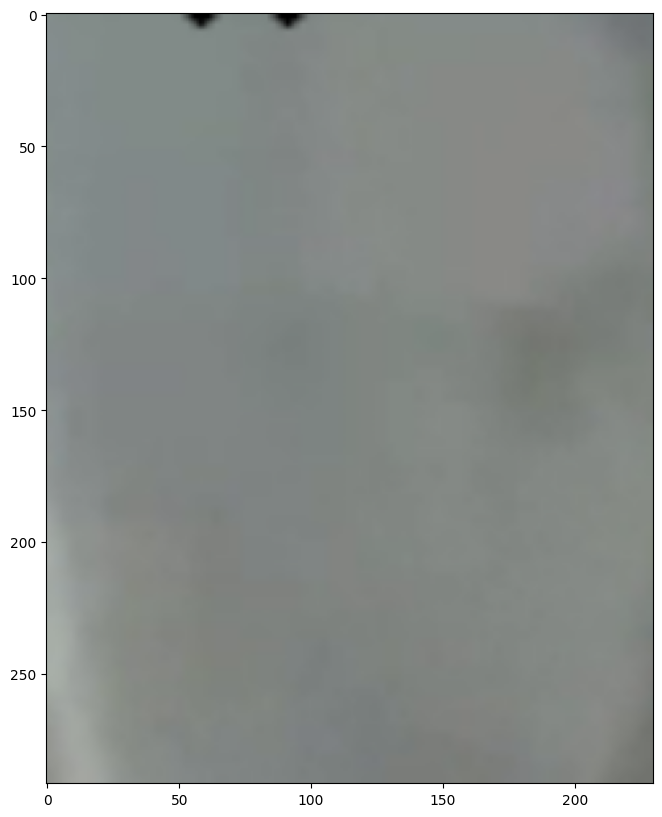

0.40378806


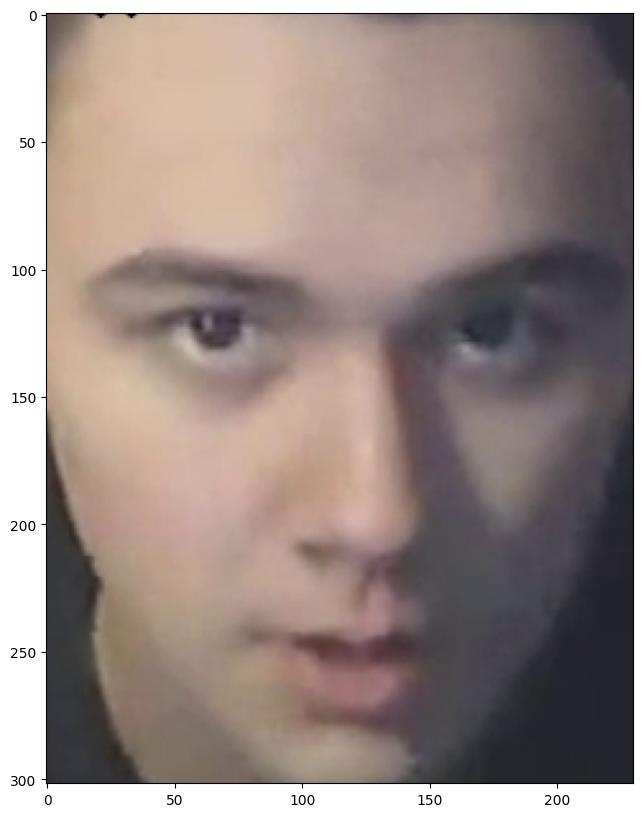

0.8576796


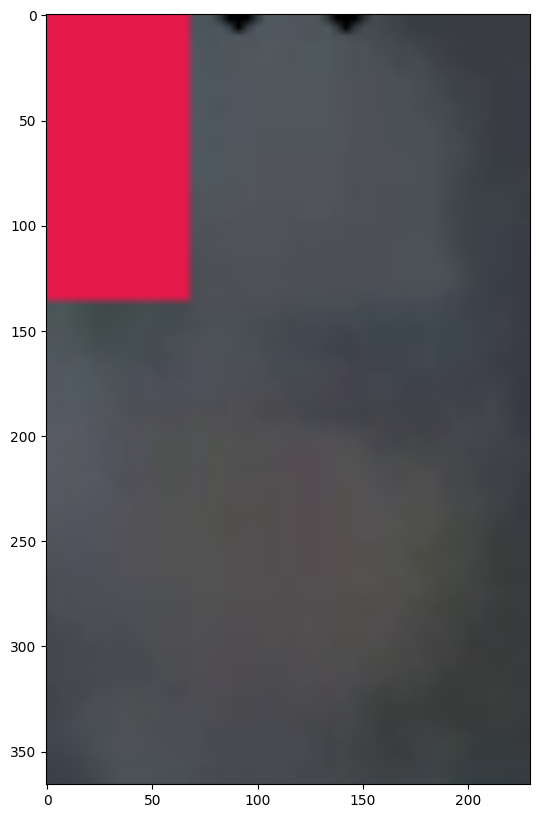

0.36809155


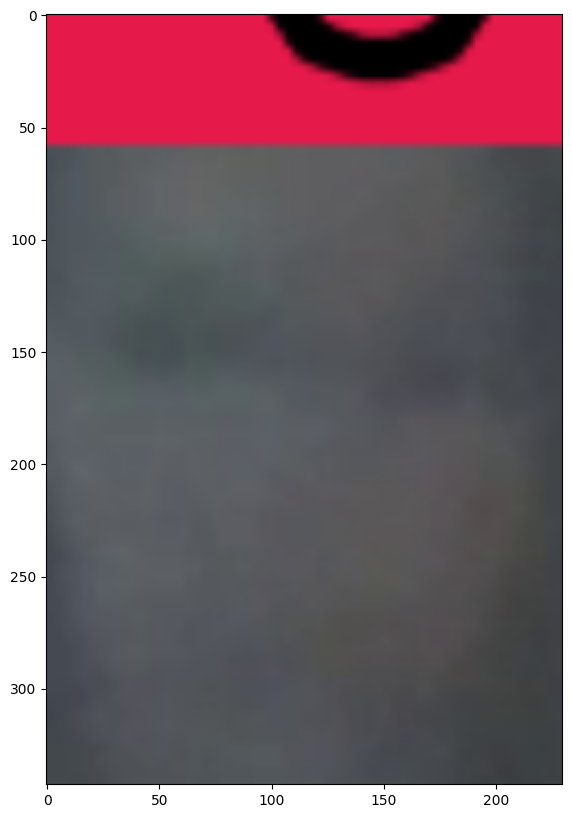

0.72883236


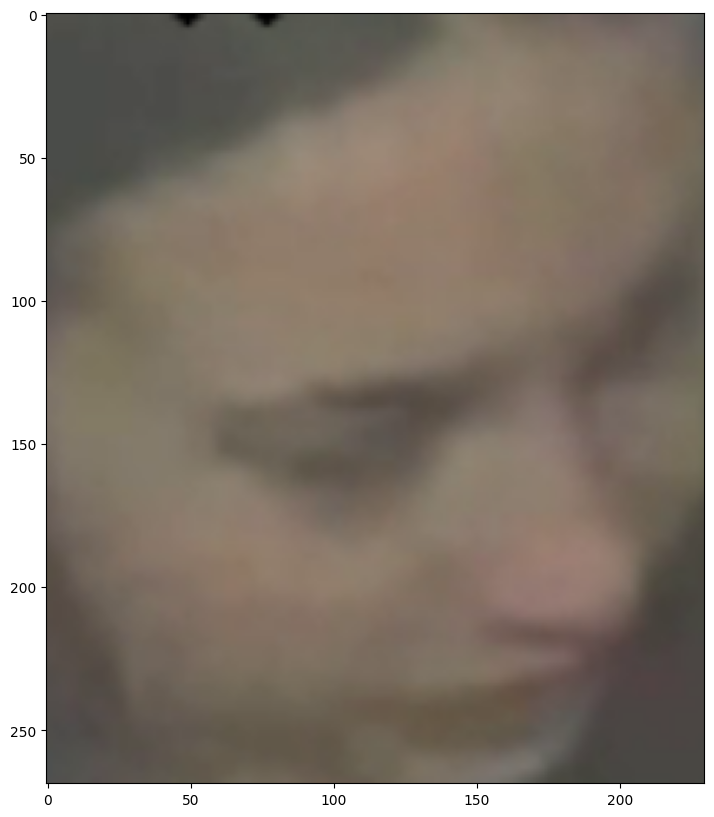

0.76811314


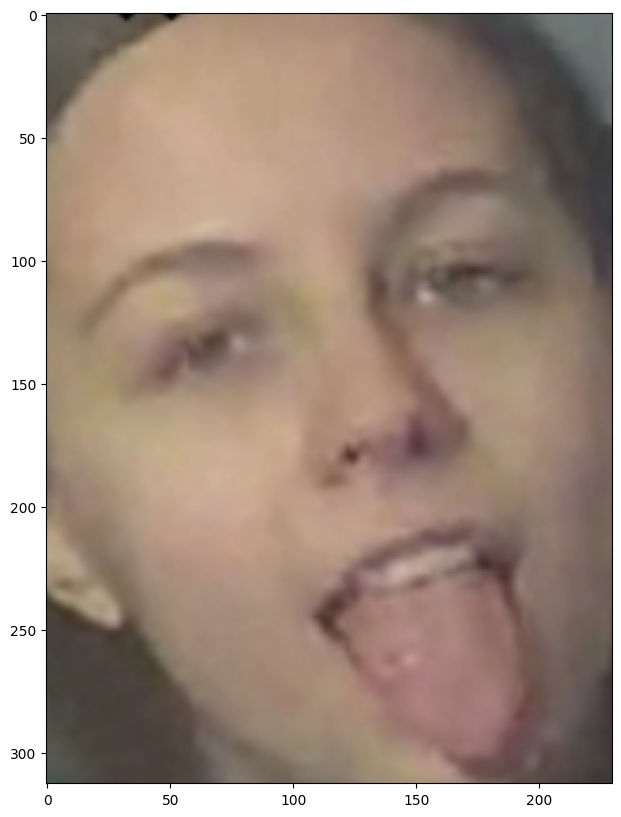

0.8475353


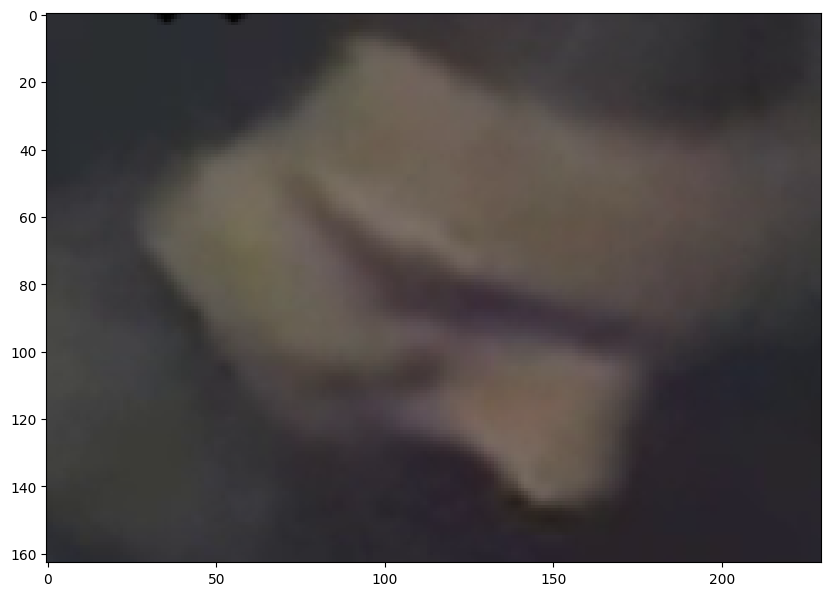

0.38771704


In [39]:
def split_by_tracker_id(data_list, key):
    groups = []
    for item in data_list:
        added = False
        for group in groups:
            if item[key] == group[0][key]:
                group.append(item)
                added = True
                break
        if not added:
            groups.append([item])
    return groups


def get_the_best_bbox(groups_by_id):
    result = []
    for group in groups_by_id:
        result.append(max(group, key=lambda x: x['confidence']))
    return result

                      
def crop_images(frames, bbox):
    # Unpack the bounding box coordinates
    x_min, y_min, x_max, y_max = bbox
    # Crop the image using the bounding box coordinates
    #cropped_image = frames.crop((x_min, y_min, x_max, y_max))    
    cropped_image = frames[int(y_min)+5:int(y_max)-5, int(x_min)+5:int(x_max)-5]
    return cropped_image

def resize_faces(images):
    returns = []
    for image in images:
        height, width = image.shape[:2]
        resized_image = image
        if (width < 230):
            desired_width = 230
            desired_height = (height*230)//width
            
            resized_image = cv2.resize(image, (desired_width, desired_height))
        returns.append(resized_image)
    return(returns)
            
            
        
    

# split data on goups by tracker id
groups_by_id = split_by_tracker_id(detected_faces, 'id')
# getting the best bbox according to confidence
best_face_images = get_the_best_bbox(groups_by_id)

# list of final images
faces_r = []
for image in best_face_images:
    faces_r.append(crop_images(image['image'], image['coordinates']))
    faces = resize_faces(faces_r)
    
    %matplotlib inline
    show_frame_in_notebook(faces[-1])
    
    
    text = 'Confidence: '+ (str(round(image['confidence'], 2)))
    print(image['confidence'])

    # Нанести текст на изображение
    image_with_text = cv2.putText(faces[-1], text, (0,13), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 1, cv2.LINE_AA)
    
    cv2.imwrite(f"detected_faces/detected_face_id{image['id']}.png", image_with_text)




## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.